In [1]:
import gym
import pybullet_envs
import pybullet_envs.bullet as bul
import numpy as np
import torch
from sac_agent import soft_actor_critic_agent, device
from replay_memory import ReplayMemory

seed=0  
env = gym.make('MinitaurBulletEnv-v0')
torch.manual_seed(seed)
np.random.seed(seed)
env.seed(seed)
max_steps = env._max_episode_steps
print('max_steps: ', max_steps)

batch_size=128 ##  512 
LEARNING_RATE=0.0001 
start_steps=10000 ## Steps sampling random actions
replay_size=1000000 ## size of replay buffer

agent = soft_actor_critic_agent(env.observation_space.shape[0], env.action_space, \
        hidden_size=256, seed=seed, lr=LEARNING_RATE, gamma=0.99, tau=0.005, alpha=0.2)

memory = ReplayMemory(replay_size)

print('device: ', device)
print('leraning rate: ', LEARNING_RATE)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

print('state_dim: ',state_dim, ', action_dim: ', action_dim)

threshold = env.spec.reward_threshold
print('threshold: ', threshold)


current_dir=/home/rafael/anaconda3/envs/ml2/lib/python3.7/site-packages/pybullet_envs/bullet
device:  cpu
urdf_root=/home/rafael/anaconda3/envs/ml2/lib/python3.7/site-packages/pybullet_data
max_steps:  1000
device:  cpu
leraning rate:  0.0001
state_dim:  28 , action_dim:  8
threshold:  15.0


In [2]:
def save(agent, directory, filename, episode, reward):
    torch.save(agent.policy.state_dict(), '%s/%s_actor_%s_%s.pth' % (directory, filename, episode, reward))
    torch.save(agent.critic.state_dict(), '%s/%s_critic_%s_%s.pth' % (directory, filename, episode, reward))

In [3]:
import time
from  collections  import deque

def sac_train(max_steps):

    total_numsteps = 0
    updates = 0
    num_episodes = 40000
    updates=0

    time_start = time.time()
    scores_deque = deque(maxlen=100)
    scores_array = []
    avg_scores_array = [] 
    num_steps_deque = deque(maxlen=100)
    avg_numm_steps_array = []
    
    for i_episode in range(num_episodes): 
        episode_reward = 0
        episode_steps = 0
        done = False
        state = env.reset()

        for step in range(max_steps):    
            if start_steps > total_numsteps:
                action = env.action_space.sample()  # Sample random action
            else:
                action = agent.select_action(state)  # Sample action from policy

            if len(memory) > batch_size:
                
                # Update parameters of all the networks
                agent.update_parameters(memory, batch_size, updates)

                updates += 1

            next_state, reward, done, _ = env.step(action) # Step
            episode_steps += 1
            total_numsteps += 1
            episode_reward += reward

            mask = 1 if episode_steps == env._max_episode_steps else float(not done)

            memory.push(state, action, reward, next_state, mask) # Append transition to memory

            state = next_state
            
            if done:
                break

        scores_deque.append(episode_reward)
        scores_array.append(episode_reward)        
        avg_score = np.mean(scores_deque)
        avg_scores_array.append(avg_score)
        min_score = np.min(scores_deque)
        max_score = np.max(scores_deque)
        num_steps_deque.append(episode_steps)
        avg_num_steps = np.mean(num_steps_deque)
        avg_numm_steps_array.append(avg_num_steps)
        
        
        if i_episode % 500 == 0 and i_episode > 0:
            reward_round = round(episode_reward, 2)
            save(agent, 'dir_lr0.0001', 'weights', str(i_episode), str(reward_round))

        s =  (int)(time.time() - time_start)
          
        if i_episode % 10 == 0 and i_episode > 0:  

            print("Ep.: {}, Tot.St.: {}, Avg.Num.St.: {:.1f}, Min-Max.Sc.: ({:.2f}, {:.2f}), Avg.Score: {:.3f}, Time: {:02}:{:02}:{:02}".\
                format(i_episode, total_numsteps, avg_num_steps, min_score, max_score, avg_score, \
                  s//3600, s%3600//60, s%60))

                    
        if (avg_score >= threshold):            
            print('Solved environment with Avg Score:  ', avg_score)
            
            break;
            
    return scores_array, avg_scores_array, avg_numm_steps_array 

scores, avg_scores, avg_numm_steps = sac_train(max_steps=max_steps)

Ep.: 10, Tot.St.: 7832, Avg.Num.St.: 712.0, Min-Max.Sc.: (-2.21, -0.14), Avg.Score: -1.176, Time: 00:10:37
Ep.: 20, Tot.St.: 12095, Avg.Num.St.: 576.0, Min-Max.Sc.: (-2.21, 0.02), Avg.Score: -0.947, Time: 00:16:30
Ep.: 30, Tot.St.: 15778, Avg.Num.St.: 509.0, Min-Max.Sc.: (-2.46, 0.02), Avg.Score: -0.940, Time: 00:21:37
Ep.: 40, Tot.St.: 17901, Avg.Num.St.: 436.6, Min-Max.Sc.: (-2.46, 0.02), Avg.Score: -0.841, Time: 00:24:36
Ep.: 50, Tot.St.: 20430, Avg.Num.St.: 400.6, Min-Max.Sc.: (-2.46, 0.02), Avg.Score: -0.731, Time: 00:28:11
Ep.: 60, Tot.St.: 23286, Avg.Num.St.: 381.7, Min-Max.Sc.: (-2.46, 0.08), Avg.Score: -0.671, Time: 00:32:11
Ep.: 70, Tot.St.: 24355, Avg.Num.St.: 343.0, Min-Max.Sc.: (-2.46, 0.08), Avg.Score: -0.604, Time: 00:33:43
Ep.: 80, Tot.St.: 25623, Avg.Num.St.: 316.3, Min-Max.Sc.: (-2.46, 0.15), Avg.Score: -0.553, Time: 00:35:31
Ep.: 90, Tot.St.: 27202, Avg.Num.St.: 298.9, Min-Max.Sc.: (-2.46, 0.15), Avg.Score: -0.529, Time: 00:37:44
Ep.: 100, Tot.St.: 29489, Avg.Num.St.

Ep.: 770, Tot.St.: 172948, Avg.Num.St.: 112.5, Min-Max.Sc.: (-0.01, 3.43), Avg.Score: 0.399, Time: 04:05:39
Ep.: 780, Tot.St.: 175165, Avg.Num.St.: 121.9, Min-Max.Sc.: (-0.01, 3.43), Avg.Score: 0.389, Time: 04:09:00
Ep.: 790, Tot.St.: 176382, Avg.Num.St.: 123.7, Min-Max.Sc.: (0.02, 3.43), Avg.Score: 0.373, Time: 04:10:53
Ep.: 800, Tot.St.: 178629, Avg.Num.St.: 136.3, Min-Max.Sc.: (-0.10, 3.43), Avg.Score: 0.388, Time: 04:14:20
Ep.: 810, Tot.St.: 180645, Avg.Num.St.: 146.4, Min-Max.Sc.: (-0.10, 3.43), Avg.Score: 0.423, Time: 04:17:26
Ep.: 820, Tot.St.: 182318, Avg.Num.St.: 151.3, Min-Max.Sc.: (-0.10, 3.43), Avg.Score: 0.469, Time: 04:20:00
Ep.: 830, Tot.St.: 183691, Avg.Num.St.: 158.3, Min-Max.Sc.: (-0.10, 3.43), Avg.Score: 0.515, Time: 04:22:09
Ep.: 840, Tot.St.: 185324, Avg.Num.St.: 166.7, Min-Max.Sc.: (-0.10, 3.43), Avg.Score: 0.541, Time: 04:24:40
Ep.: 850, Tot.St.: 186193, Avg.Num.St.: 168.2, Min-Max.Sc.: (-0.10, 3.43), Avg.Score: 0.550, Time: 04:26:04
Ep.: 860, Tot.St.: 187015, Av

Ep.: 1530, Tot.St.: 390128, Avg.Num.St.: 352.3, Min-Max.Sc.: (0.17, 13.80), Avg.Score: 4.241, Time: 12:33:21
Ep.: 1540, Tot.St.: 395124, Avg.Num.St.: 370.4, Min-Max.Sc.: (0.17, 14.64), Avg.Score: 4.577, Time: 12:47:15
Ep.: 1550, Tot.St.: 399625, Avg.Num.St.: 384.7, Min-Max.Sc.: (0.22, 15.60), Avg.Score: 4.930, Time: 12:59:45
Ep.: 1560, Tot.St.: 406670, Avg.Num.St.: 409.2, Min-Max.Sc.: (0.22, 18.37), Avg.Score: 5.570, Time: 13:19:25
Ep.: 1570, Tot.St.: 413715, Avg.Num.St.: 451.8, Min-Max.Sc.: (0.22, 18.37), Avg.Score: 6.319, Time: 13:39:07
Ep.: 1580, Tot.St.: 419703, Avg.Num.St.: 487.8, Min-Max.Sc.: (0.22, 18.37), Avg.Score: 7.091, Time: 13:55:53
Ep.: 1590, Tot.St.: 426830, Avg.Num.St.: 525.7, Min-Max.Sc.: (0.22, 20.79), Avg.Score: 8.002, Time: 14:15:46
Ep.: 1600, Tot.St.: 436015, Avg.Num.St.: 570.8, Min-Max.Sc.: (0.22, 20.79), Avg.Score: 9.178, Time: 14:41:30
Ep.: 1610, Tot.St.: 445347, Avg.Num.St.: 635.4, Min-Max.Sc.: (0.22, 20.80), Avg.Score: 10.602, Time: 15:07:38
Ep.: 1620, Tot.St.

In [4]:
reward_round = round(np.max(scores), 2)
save(agent, 'dir_lr0.0001', 'weights', 'final', str(reward_round))

length of scores:  1745 , len of avg_scores:  1745


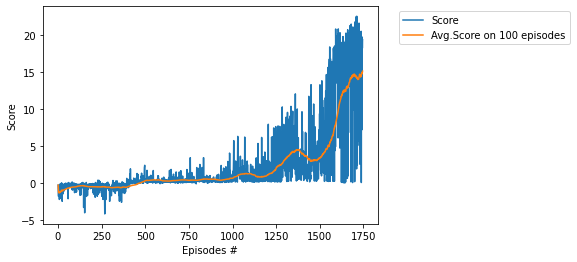

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

print('length of scores: ', len(scores), ', len of avg_scores: ', len(avg_scores))

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores, label="Score")
plt.plot(np.arange(1, len(avg_scores)+1), avg_scores, label="Avg.Score on 100 episodes")
## plt.plot(np.arange(1, len(avg_numm_steps)+1), avg_numm_steps, label="Avg.Num.Steps on 100 episodes")
plt.legend(bbox_to_anchor=(1.05, 1)) 
plt.ylabel('Score')
plt.xlabel('Episodes #')
plt.show()

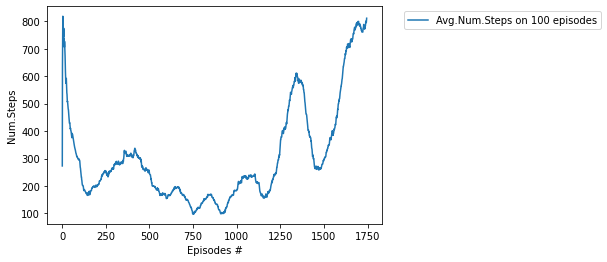

In [7]:
fig2 = plt.figure()
ax = fig2.add_subplot(111)
# plt.plot(np.arange(1, len(scores)+1), scores, label="Score")
# plt.plot(np.arange(1, len(avg_scores)+1), avg_scores, label="Avg.Score on 100 episodes")
plt.plot(np.arange(1, len(avg_numm_steps)+1), avg_numm_steps, label="Avg.Num.Steps on 100 episodes")
plt.legend(bbox_to_anchor=(1.05, 1)) 
plt.ylabel('Num.Steps')
plt.xlabel('Episodes #')
plt.show()

In [8]:
def play(env, agent, num_episodes):
    
    state = env.reset()
    scores_deque = deque(maxlen=100)
    scores = []
    
    for i_episode in range(num_episodes + 1):
        
        state = env.reset()
        score = 0                    
        time_start = time.time()
        
        while True:
            
            action = agent.select_action(state, eval=False)
            env.render()
            next_state, reward, done, _ = env.step(action)
            score += reward 
            state = next_state
    
            if done:
                break
                
        s = (int)(time.time() - time_start)
        
        scores_deque.append(score)
        scores.append(score)    
        
        print('Episode {}\tAverage Score: {:.2f},\tScore: {:.2f} \tTime: {:02}:{:02}:{:02}'\
                  .format(i_episode, np.mean(scores_deque), score, s//3600, s%3600//60, s%60)) 
    

In [ ]:
#import pybullet_envs.bullet.minitaur_gym_env as e
#env_render = e.MinitaurBulletEnv(render=True)
#play(env=env_render, agent=agent, num_episodes=5)

In [ ]:
env.close()